# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import GridSearchCV

# Day

### Load Dataset

In [2]:
# Load daily dataset
day_url = "https://raw.githubusercontent.com/michaeldavidsinn/csvml/refs/heads/main/day.csv"
day_df = pd.read_csv(day_url)

In [3]:
# Show dataset
day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


### Pre-Processing

In [4]:
# Show missing values
print(day_df.isnull().sum())

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [5]:
# Show info
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [6]:
# Describe data
day_df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [7]:
# Convert 'dteday' to datetime format and set index
day_df['dteday'] = pd.to_datetime(day_df['dteday'])
day_df.set_index('dteday', inplace=True)

In [8]:
# Selected features for daily modeling
selected_features = ['temp', 'hum', 'windspeed', 'season', 'weathersit', 'yr', 'mnth', 'holiday', 'weekday', 'workingday']

In [9]:
# Scale the features for XGBoost (daily data)
scaler = StandardScaler()
day_df[selected_features] = scaler.fit_transform(day_df[selected_features])

In [10]:
# Split day data into train and test sets
X_day = day_df[selected_features]
y_day = day_df['cnt']

X_train_day, X_test_day, y_train_day, y_test_day = train_test_split(X_day, y_day, test_size=0.2, random_state=42)

### Visualization

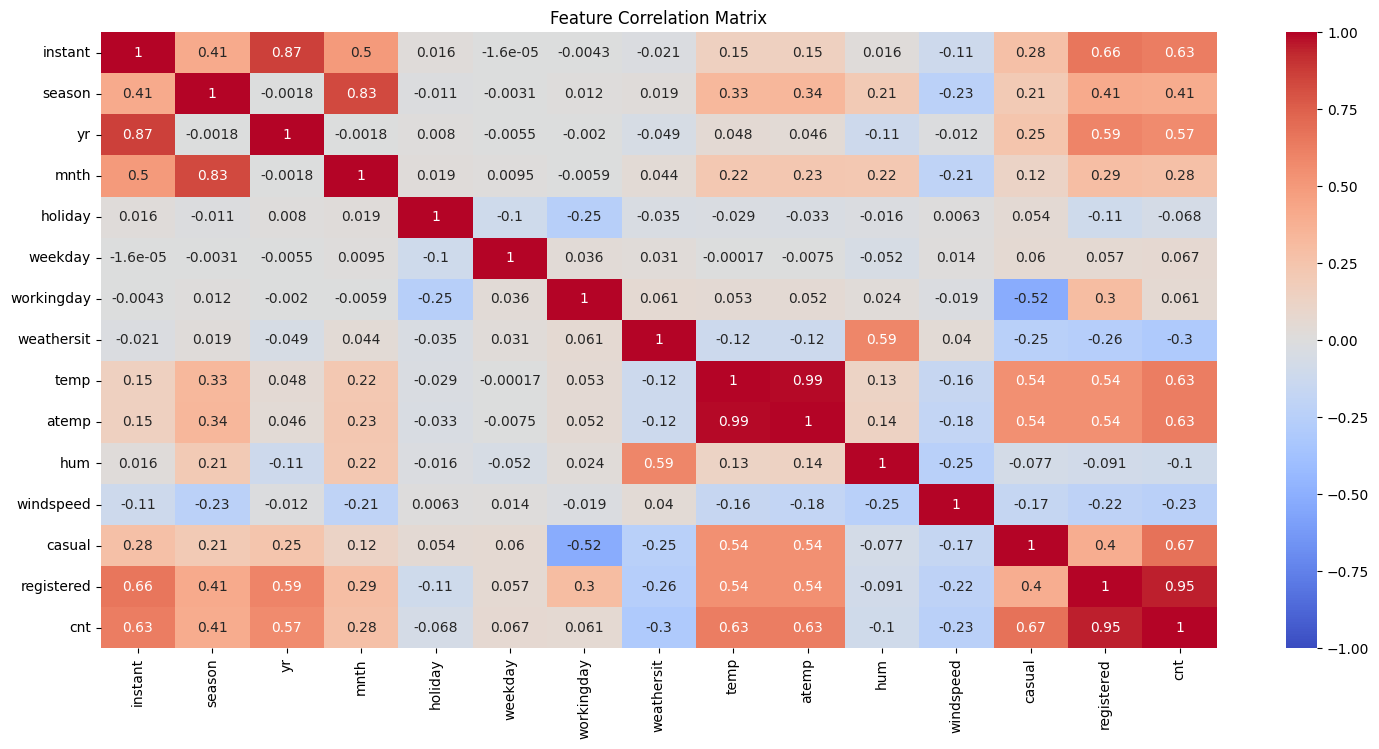

In [11]:
# Visualize using Correlation Matrix
correlation_matrix = day_df.corr()

plt.figure(figsize=(18, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

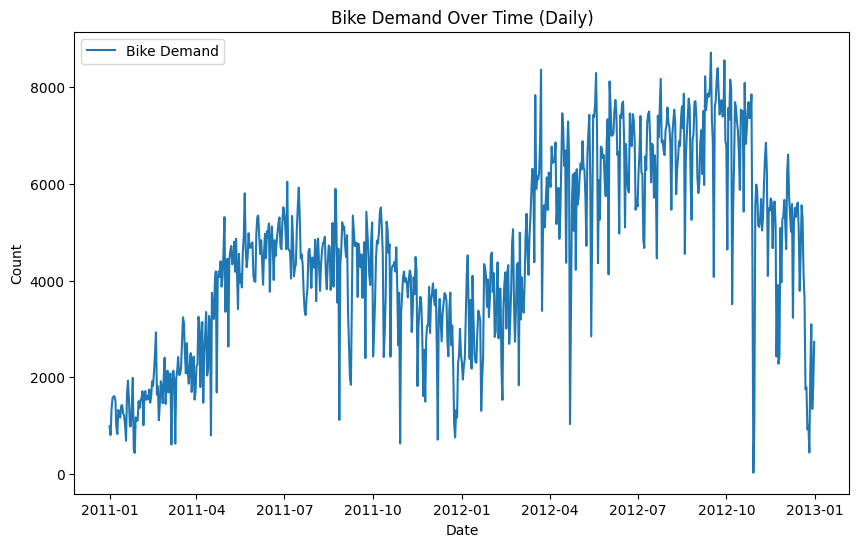

In [12]:
# Visualize the bike demand data (daily)
plt.figure(figsize=(10, 6))
plt.plot(day_df['cnt'], label="Bike Demand")
plt.title("Bike Demand Over Time (Daily)")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.show()

### Processing

In [13]:
# SARIMAX model fitting (daily)
sarimax_model = SARIMAX(day_df['cnt'],
                        exog=day_df[selected_features],
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 12),  # Monthly seasonality
                        enforce_stationarity=False,
                        enforce_invertibility=False)
results = sarimax_model.fit()

sarimax_predictions = results.predict(start=day_df.index[0], end=day_df.index[-1], exog=day_df[selected_features])
residuals = day_df['cnt'] - sarimax_predictions


/Users/stvn/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/stvn/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.92217D+00    |proj g|=  1.12267D-01

At iterate    5    f=  7.87485D+00    |proj g|=  3.58354D-02

At iterate   10    f=  7.87243D+00    |proj g|=  4.46103D-03

At iterate   15    f=  7.87241D+00    |proj g|=  2.41809D-03

At iterate   20    f=  7.87215D+00    |proj g|=  3.17777D-02

At iterate   25    f=  7.85548D+00    |proj g|=  1.31084D-01

At iterate   30    f=  7.78621D+00    |proj g|=  1.44673D-01

At iterate   35    f=  7.75894D+00    |proj g|=  1.85080D-02

At iterate   40    f=  7.75847D+00    |proj g|=  7.32573D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [14]:
X_train_residuals = X_train_day
y_train_residuals = residuals.loc[X_train_day.index]

In [15]:
# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
xgb_model = XGBRegressor(random_state=42)

In [16]:
# Perform GridSearch 
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_residuals, y_train_residuals)
best_xgb_model = grid_search.best_estimator_
print(f"Best XGBoost Parameters (Daily): {grid_search.best_params_}")

Best XGBoost Parameters (Daily): {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}


In [17]:
# Predict residuals using tuned XGBoost model (daily)
xgb_residual_predictions = best_xgb_model.predict(X_train_residuals)

In [18]:
day_df[selected_features]

,temp,hum,windspeed,season,weathersit,yr,mnth,holiday,weekday,workingday
dteday,,,,,,,,,,
2011-01-01,-0.826662,1.250171,-0.387892,-1.348213,1.110427,-1.001369,-1.600161,-0.171981,1.498809,-1.471225
2011-01-02,-0.721095,0.479113,0.749602,-1.348213,1.110427,-1.001369,-1.600161,-0.171981,-1.496077,-1.471225
2011-01-03,-1.634657,-1.339274,0.746632,-1.348213,-0.726048,-1.001369,-1.600161,-0.171981,-0.996930,0.679706
2011-01-04,-1.614780,-0.263182,-0.389829,-1.348213,-0.726048,-1.001369,-1.600161,-0.171981,-0.497782,0.679706
2011-01-05,-1.467414,-1.341494,-0.046307,-1.348213,-0.726048,-1.001369,-1.600161,-0.171981,0.001366,0.679706
...,...,...,...,...,...,...,...,...,...,...
2012-12-27,-1.318665,0.175807,2.061426,-1.348213,1.110427,0.998633,1.588660,-0.171981,0.500513,0.679706
2012-12-28,-1.323224,-0.266238,-0.452131,-1.348213,1.110427,0.998633,1.588660,-0.171981,0.999661,0.679706
2012-12-29,-1.323224,0.878392,-0.853552,-1.348213,1.110427,0.998633,1.588660,-0.171981,1.498809,-1.471225


### Evaluation

In [19]:
# Predict using SARIMAX and XGBoost for the entire dataset (daily)
sarimax_predictions_full = results.predict(start=day_df.index[0], end=day_df.index[-1], exog=day_df[selected_features])
xgb_residual_predictions_full = best_xgb_model.predict(day_df[selected_features])

In [20]:
# Combine SARIMAX and XGBoost predictions (daily)
final_predictions = sarimax_predictions_full + xgb_residual_predictions_full

In [21]:
# Evaluate combined model (daily)
mae_combined = mean_absolute_error(day_df['cnt'], final_predictions)
mse_combined = mean_squared_error(day_df['cnt'], final_predictions)
r2_combined = r2_score(day_df['cnt'], final_predictions)
print(f"Combined Model MAE (Daily): {mae_combined:.2f}")
print(f"Combined Model MSE (Daily): {mse_combined:.2f}")
print(f"Combined Model R2 (Daily): {r2_combined:.2f}")

Combined Model MAE (Daily): 489.33
Combined Model MSE (Daily): 469483.88
Combined Model R2 (Daily): 0.87


### Model Result

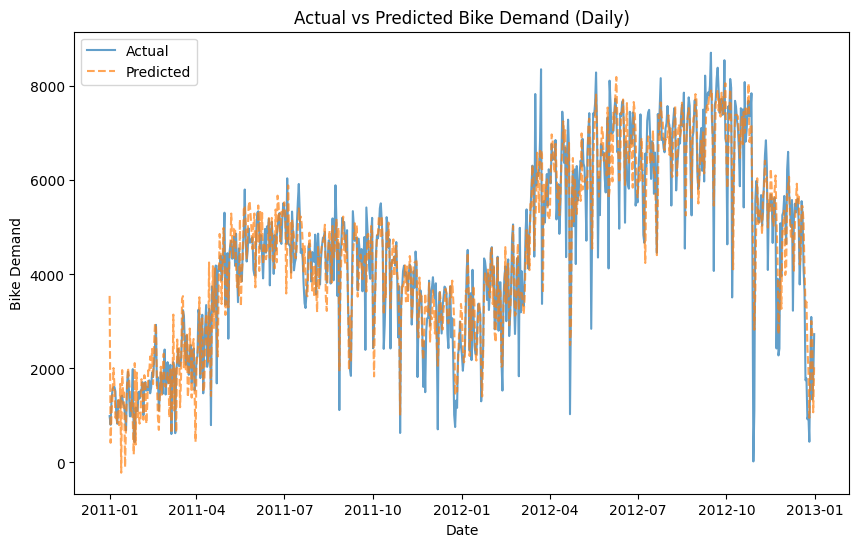

In [22]:
# Visualize actual vs predicted values (daily)
plt.figure(figsize=(10, 6))
plt.plot(day_df['cnt'], label="Actual", alpha=0.7)
plt.plot(final_predictions, label="Predicted", linestyle='--', alpha=0.7)
plt.title("Actual vs Predicted Bike Demand (Daily)")
plt.xlabel("Date")
plt.ylabel("Bike Demand")
plt.legend()
plt.show()